### 데이터 불러오기 / Import

In [66]:
, precision_recall_curve
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.base import clone, BaseEstimator
from sklearn.metrics import confusion_matrix,precision_score, recall_score,f1_score,precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

import numpy as np

In [2]:
, fetch_openml
#MNIST 데이터셋 불러오기
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1, as_frame = False)
mnist.keys()

/usr/local/lib/python3.9/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

이미지가 70000개 특성은 784개 있다 이미지 픽셀이 28 * 28 이기 떄문이다   
개개의 특성은 단순히 0(흰색) ~ 255(검은색)까지 픽셀 강도를 나타낸다 

### 데이터 확인

In [3]:
X, y = mnist['data'],mnist['target']
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

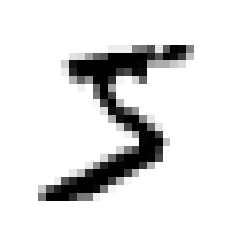

In [5]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28) #샘플 특성 백터를 추출하여 28*28배열로 크기 바꾸기

plt. imshow(some_digit_image, cmap='binary')#imshow함수로 그리기
plt.axis('off')
plt.show()

In [6]:
y[0] #실제 레이블 확인

'5'

In [7]:
y = y.astype(np.uint8) #y를 정수로 변환

In [79]:
# 그림 그리는 기능을 함수로 만들어두자.
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다. 
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

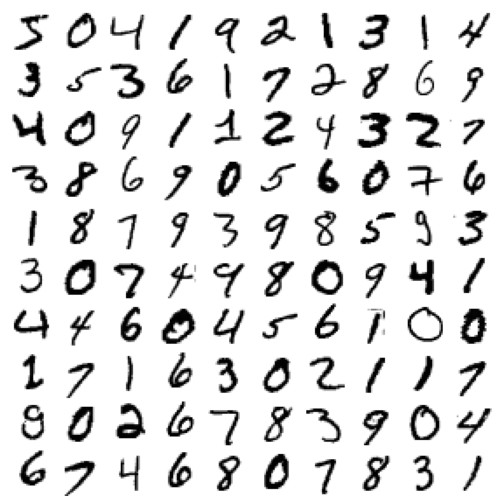

In [80]:
plt.figure(figsize=(9,9))
example_images = X[:100] # 100개만 출력
plot_digits(example_images, images_per_row=10)
plt.show()

In [8]:
#데이터를 조사하기전 테스트 세트 만들어 놓기
#어떤 학습 알고리즘은 훈련 샘플의 순서에 민감, 많은 비슷한 샘플이 연이어 나타나면 성능 저하 
#데이터 셋을 썩으면 이런 문제 방지(이미 훈련세트는 섞여 있음)
X_train, X_test, y_train, y_test = X[:60000], X[60000:],y[:60000],y[60000:]

### 이진분류기훈련
확률적 경사 하강법(SGD)  
- 무작위로 학습데이터셋에서 한개의 샘플 데이터 셋을 추출하고 그 샘플에 대해서만 기울기를 계산
- 샘플 데이터 셋에 대해서만 경사를 계산하므로, 매번 반복에서 다뤄야 할 데이터 수가 매우 적어, 학습 속도가 매우빠르다
- 하나의 샘플만 대상으로 경사를 계산하므로, 메모리 소모량이 매우 맞으며, 매우 큰 훈련 데이터 셋이라 할 지라고 학습이 가능하다
- 그러나 무작위로 추출된 샘플에 대해서 경사를 구하므로 배치 경사 하강법보다 훨씬 불안정하게 움직인다
- 즉 SGD는 속도가 매우 빠르고 메모리를 적게 먹는다는 장점이 있으나 경사를 구할때 무작위성을 띄므로 지역 최솟값에서 탈출하기 쉬우나, 전역 최솟값에 다다르기 힘들다는 단점을 가지고 있다
- 이문제를 해결하기 위해서 미니 배치 경사 하강법이 등장했다
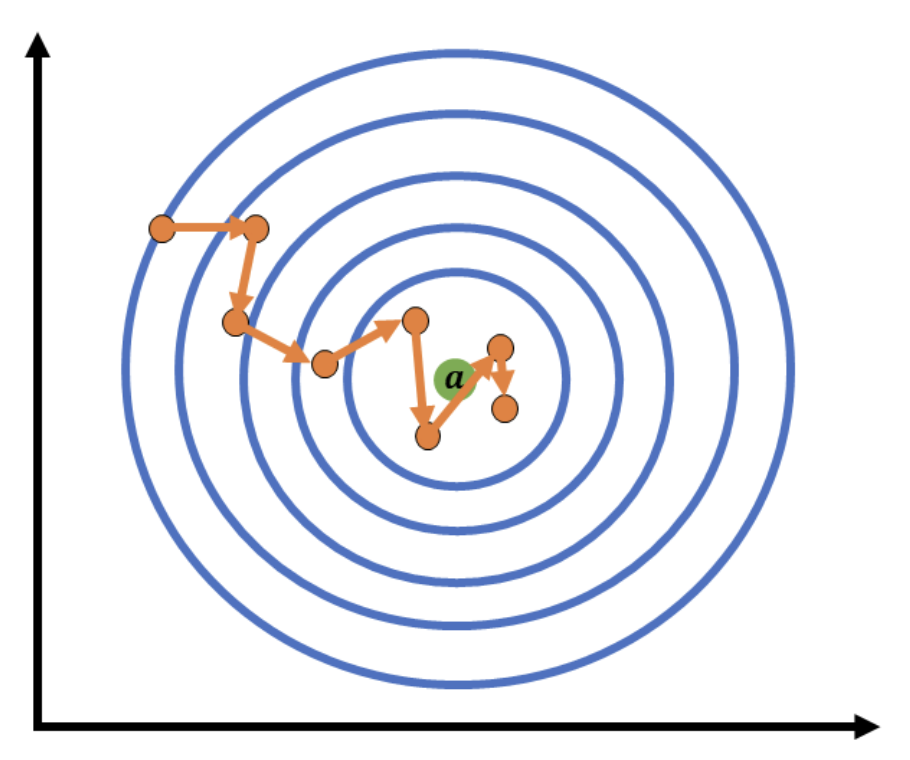

In [9]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [10]:
#random_state = 수행시 결과값을 동일하게 맞춰주기 위함, 어떤 값을 적어도 상관없음
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
sgd_clf.predict([some_digit])

array([ True])

### 성능측정

In [12]:
#교차검증구현
#폴드가 3개인 교차검증 훈련세트
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [13]:
# cross_cal_socre을 통해 폴드가 3개인 K-겹 교차검증 사용하여 모델평가
# 각폴드에 대해 예측을 만들고 평가하기 위해 나머지 폴드로 훈련시킨 모델을 사용해야한다
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [14]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [15]:
naver_5_clf = Never5Classifier()
cross_val_score(naver_5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.91125, 0.90855, 0.90915])

#### 오차행렬로 성능평가    
오차행렬을 만들려면 실제 타깃과 비교할 수 있도록 먼저 예측값을 만들어야 합니다. 테스트 세트로 예측을 만들 수 있지만 여기서 사용하면 안됨 대신 cross_val_predict()함수 사용 가능

cross_val_predict     
cross_val_predict는 cross_val_score() 함수처럼 K-겹 교차검증을 수행하지만 평가점수를 반환하지 않고     
각 테스트 폴드에서 얻은 예측을 반환합니다
훈련세트의 모든 샘플에 대해서 깨끗한 예측을 얻게 됩니다    
(모델이 훈련하는 동안 
보지 못했던 데이터에 대해서 예측했다는 의미)

In [16]:
#오차행렬로 성능평가 : 잘못분류된 횟수를 세는 것
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

오차행렬 첫번째 행은 5아님 이미지 53892개를 정확하게 분류했고 나머지 687개는 잘못분류함    
1325개를 5아님으로 잘못분류했고 나머지 3530개를 정확하게 5라고 분류함

In [17]:
# confusion_matrix(오차행렬) : 타겟클래스, 예측클레스 넣고 호출하면 됨
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

정밀도와 재현율

In [18]:
#정확도
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [19]:
#감지
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [20]:
#정밀도와 재현율을 f1score라고 하는 하나의 숫자로 만듬
f1_score(y_train_5, y_train_pred)

0.7325171197343846

#### 정밀도/재현율 트레이드오프

임계값
- 애매한 값을 이분법으로 확실히 분류할 기준이 필요함 이 기준을 임계값이라고 함, 로지스틱 회귀 값을 이진 카테고리에 매핑하려면 분류 임계값을 정의해야함

In [21]:
#각 샘플의 점수를 확인하여 임계값을 정해 예측을 만든다
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [22]:
#SGDClass 임계값이 0이므로 predict() 메서드와 같은 결과를 반환
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [23]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [24]:
#cross_val_predict()함수를 사용하여 훈련세트에 있는 샘플의 점수를 구해
# 예측 결과가 아니라 결정점수를 반환받는다
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3,
                             method = "decision_function")

In [25]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [26]:
#위의 점수로 Precision_recall_curve()함수를 사용하여 사용가능한
#임계값에 대한 정밀도 재현율 계산
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [27]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "정밀도")
    plt.plot(thresholds, recalls[:-1], "g-", label = "재현율")

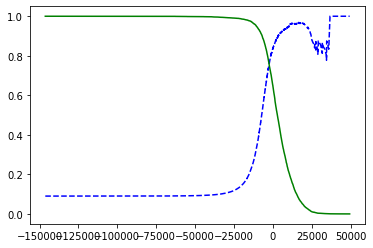

In [28]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [29]:
#최소한 90% 정밀도가 되는 가장 낮은 임계값
threshold_90 = thresholds[np.argmax(precisions >= 0.90)]

In [30]:
threshold_90

3370.0194991439557

In [31]:
y_train_pred_90 = (y_scores >= threshold_90)

In [32]:
#정밀도 확인
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [33]:
#재현율 확인
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

#### roc곡선
- 수신기 조작특성(ROC)곡선도 이진분류에서 널리 사용하는 도구
- 정밀도/재현율 곡선과 매우 비슷하지만 거짓양성비율(FPR),진짜양성비율(TPR)의 곡선
- 양성으로 잘못분류된 음성 샘플의 비율 FPR, 1에서 진짜음성비율 TNR을 뺸 값
- TNR을 특이도라고 함, ROC곡선은 민감도에 대한 1-특이도 그래프임

In [34]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

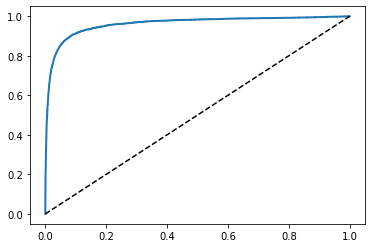

In [35]:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')
plot_roc_curve(fpr, tpr)
plt.show()

In [36]:
#곡선 아래의 면적
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

randomforest와 SGDClassifier 비교

In [37]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method = 'predict_proba')

In [38]:
y_scores_forest = y_probas_forest[:, 1] # 양성클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

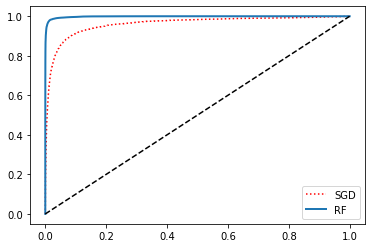

In [39]:
plt.plot(fpr, tpr, 'r:', label = 'SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'RF')
plt.legend(loc = 'lower right')
plt.show()

In [40]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

#### 다중분류
- SGD 분류기, 랜덤 포레스트 분류기, 나이브 베이즈 분류기등 여러개 클래스 직접 처리가능
- 로스틱 회귀, 서포트 벡터 머신 같은 분류기는 이진분류만 가능하나 여러개 사용해서 다중클래스 분류 하는 기법도 있음
- OvR전략 : 숫자별 이진분류기 10개를 훈련시켜 각분류기의 결정점수중 가장 높은 클래스로 선택
-OvO전략 : 0과 1구별, 0과 2 구별, 1과 2 구별 등과 같이 숫자의 조합마다 이진분류기 훈련
클래스가 N개라면 N*(N-1)/2개 필요 // 장점 : 각 분류기의 전체 훈련세트중 구별 할 두 클래스에 해당하는 샘플만 
- 다중클래스 분류작업에 이진분류 알고리즘을 선택하면 자동으로 OvR, OvO를 실행합니다. 

SVC(Support Vector Classification)
- 서포트 벡터 머신(SVM)은 여백을 최대화하는 초평면을 찾는 지도 학습 알고리즘
- SVC는 SVM의 분류 서포트 벡터머신의 한 종류
- 여백(Margin)란? 주어진 데이터가 오류를 발생시키지 않고 움직일 수 있는 최대 공간
- 분류, 회귀 여백이 클수록 새로운데이터가 들어왔을때 오류를 발생시키지 않을 가능성이 큼

In [41]:
#테스트
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [42]:
#내부에서 사이킷런이 OvO전략을 사용하여 45개의 이진분류기 훈련
# 확인 (가장 높은 점수가 5에 해당)
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [43]:
np.argmax(some_digit_scores)

5

In [44]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [45]:
svm_clf.classes_[5]

5

In [46]:
# OneVsOneClassifier or OnevsRestClassifier를 사용하여 강제로 사용하게 하기
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [47]:
len(ovr_clf.estimators_)

10

In [48]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [49]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [50]:
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = 'accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [51]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring = 'accuracy')

array([0.8983, 0.891 , 0.9018])

### 에러분석

In [54]:
#오차행렬 살펴보기
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

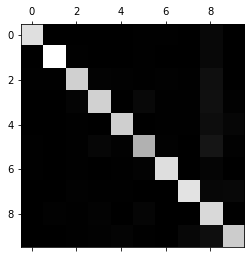

In [55]:
#이미지가 올바르게 분류되었음을 나타내주는 대각선
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [56]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

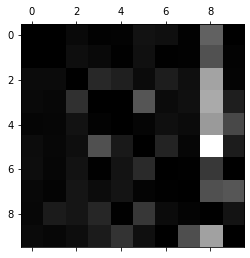

In [57]:
#분류기가 만든 에러를 확실히 볼 수 있게 주대각선만 0으로 채우기
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

위의 이미지를 확인하면 상당히 많은 이미지가 8로 잘못 분류되었음을 암시  
하지만 클래스 8행은 적절히 8로 분류 되었다는걸 알 수 있음, 이미지 전처리 필요   
3,5도 꽤 많이 분류가 잘못되었는데 3,5의 샘플을 통해 확인해 보겠음

In [76]:
cl_a, cl_b = 3,5
X_aa = X_train[(y_train == cl_a)&(y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a)&(y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b)&(y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b)&(y_train_pred == cl_b)]


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

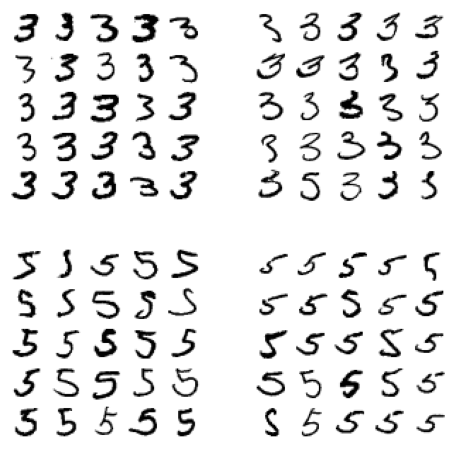

In [81]:
plt.figure(figsize = (8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

#### 다중분류레이블

In [67]:
y_train_large = (y_train >=7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier() #(KNN)
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [68]:
knn_clf.predict([some_digit]) #some_digit = 5

array([[False,  True]])

In [71]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv =3)
f1_score(y_multilabel, y_train_knn_pred, average = 'macro')

0.976410265560605

#### 다중 출력 분류

In [90]:
# randint()함수를 사용하여 픽셀 강도에 잡음 추가
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

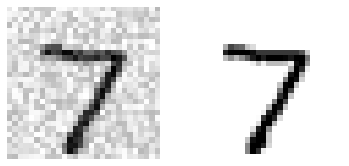

In [92]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
# save_fig("noisy_digit_example_plot")
plt.show()

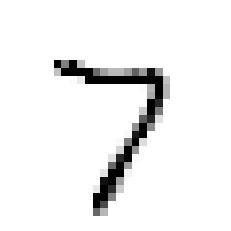

In [94]:
#분류기 훈련을 통한 이미지 깨끗하게 만들기
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)